In [1]:
import matplotlib.pyplot as plt
import numpy as np
import py21cmfast as p21c
import logging, os
from datetime import datetime

## Set logger to log caching activity

In [2]:
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

## Reset cache location 

In [3]:
p21c.config['direc'] = '/lustre/aoc/projects/hera/wchin/21cmFAST-cache'

## Colorbar function

In [4]:
def colorbar(mappable, plot_color='white'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.ylabel(f'Neutral Fraction, $x_{{HI}}$', color=plot_color)
    plt.tick_params(color=plot_color, labelcolor=plot_color)
    plt.sca(last_axes)
    
    ax.tick_params(color=plot_color, labelcolor=plot_color)
    
#     for spine in ax.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
        
#     for spine in fig.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
    
    return cbar

## Cosmological Parameters (Default is used when no input is specified)

In [5]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [56]:
BOX_LEN=301  # 300, 301
HII_DIM=301  # 450, 301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length in Mpc
    DIM=4*HII_DIM,      # Number of Voxels for hight resolution 
    HII_DIM=HII_DIM,  # Number of Voxels for low resolution 
    N_THREADS=os.cpu_count()
)

## Creating initial conditions box

In [57]:
start_time = datetime.now()
print(f'Excution qued at {start_time}')

init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params,
    direc='/lustre/aoc/projects/hera/wchin/21cmFAST-cache'
)

end_time = datetime.now()
execution_time = end_time - start_time
print(f'Execution completed at {end_time}')
print(f'Execution time = {execution_time}')

Excution qued at 2020-12-31 18:20:48.314233


2020-12-31 18:34:55,390 | INFO | Existing init_boxes found and read in (seed=230806296593).


Execution completed at 2020-12-31 18:35:01.488236
Execution time = 0:14:13.174003


# Ionized box

In [58]:
illustration_box = p21c.ionize_box(
    redshift=6.5, 
    init_boxes=init_cond,
).xH_box

2020-12-31 18:35:11,194 | INFO | Existing z=6.5 ionized boxes found and read in (seed=230806296593).


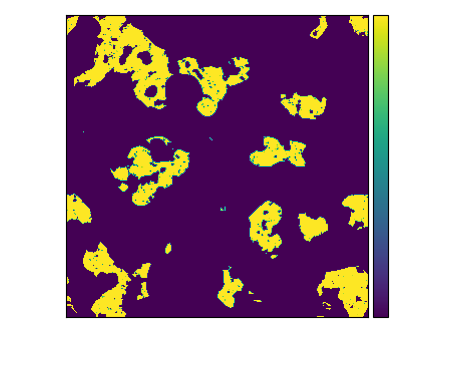

In [69]:
plt.figure(dpi=100)
color='w'
im = plt.imshow(
    illustration_box[150, :, :], 
    extent=(0,np.shape(illustration_box)[1],0,np.shape(illustration_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

In [74]:
def reduceResolution(data, rows, cols, deps):
    from skimage.transform import resize
    return resize(data, (rows, cols, deps), mode='constant')
#     return data.reshape(rows, data.shape[0]//rows, cols, data.shape[1]//cols, deps, data.shape[2]//deps).sum(axis=1).sum(axis=2).sum(axis=3)

In [75]:
def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

In [76]:
def reducedBox(newDIM):
    return normalize(reduceResolution(illustration_box, newDIM, newDIM, newDIM))

In [77]:
ap = np.round(reducedBox(3))

def colorplot(z):

    color='w'

    plt.figure(dpi=280.5, facecolor='#404040')
    im = plt.imshow(
        ap[z, :, :],
        extent=(0., BOX_LEN, 0., BOX_LEN),
        vmin=np.min(ap[z]), 
        vmax=np.max(ap[z]), 
        origin='lower'
    )

    plt.tick_params(color=color, labelcolor=color)
    colorbar(im)
    plt.title(f'z = {z}', color=color)
    plt.xlabel('Mpc', color=color)
    plt.ylabel('Mpc', color=color)
    plt.show()

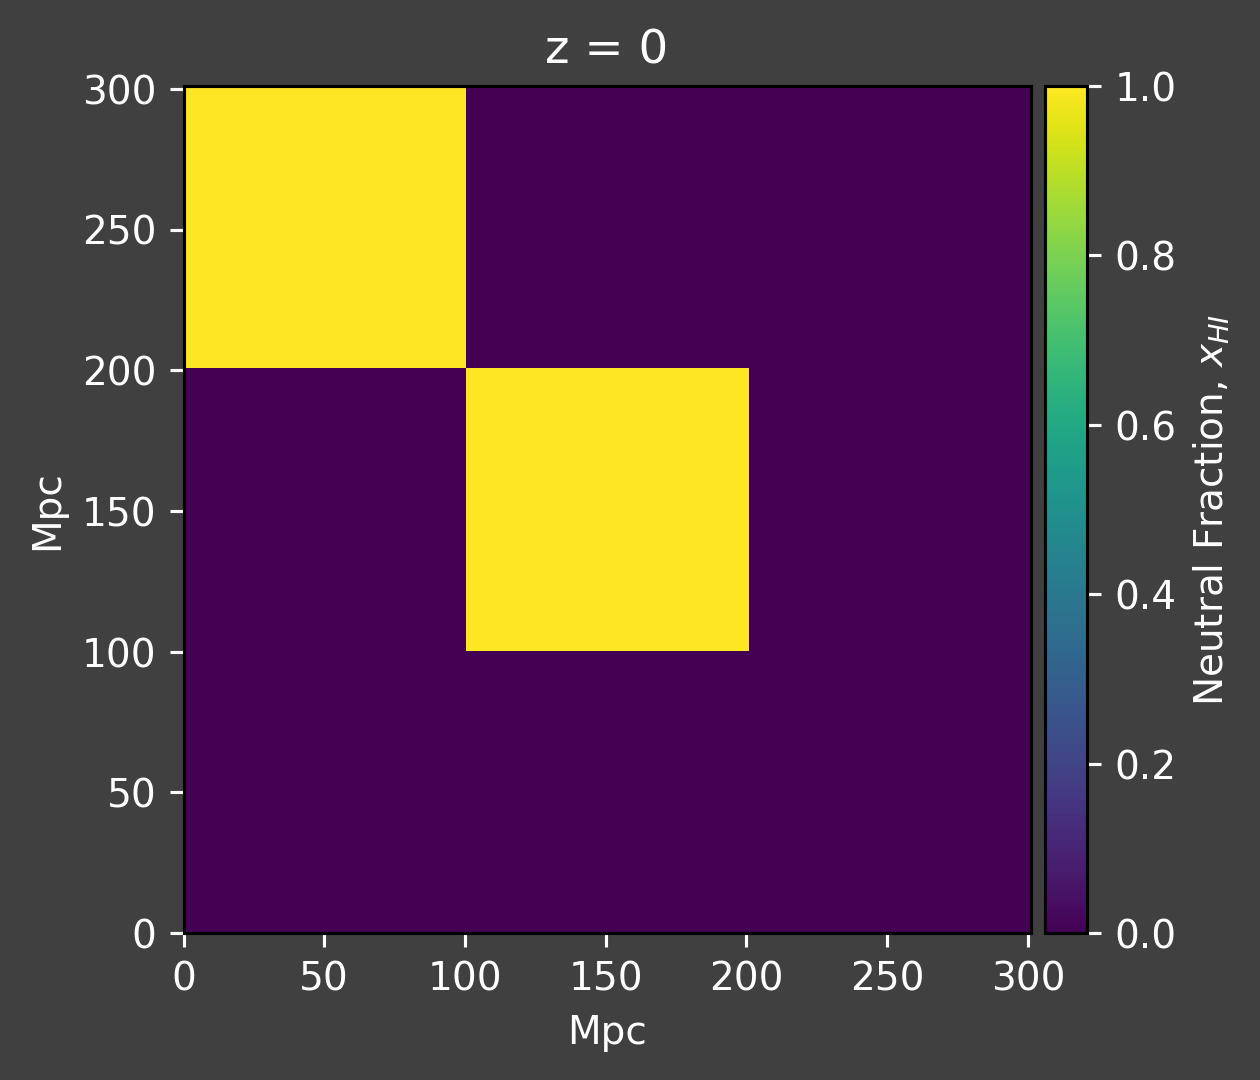

In [78]:
colorplot(0)

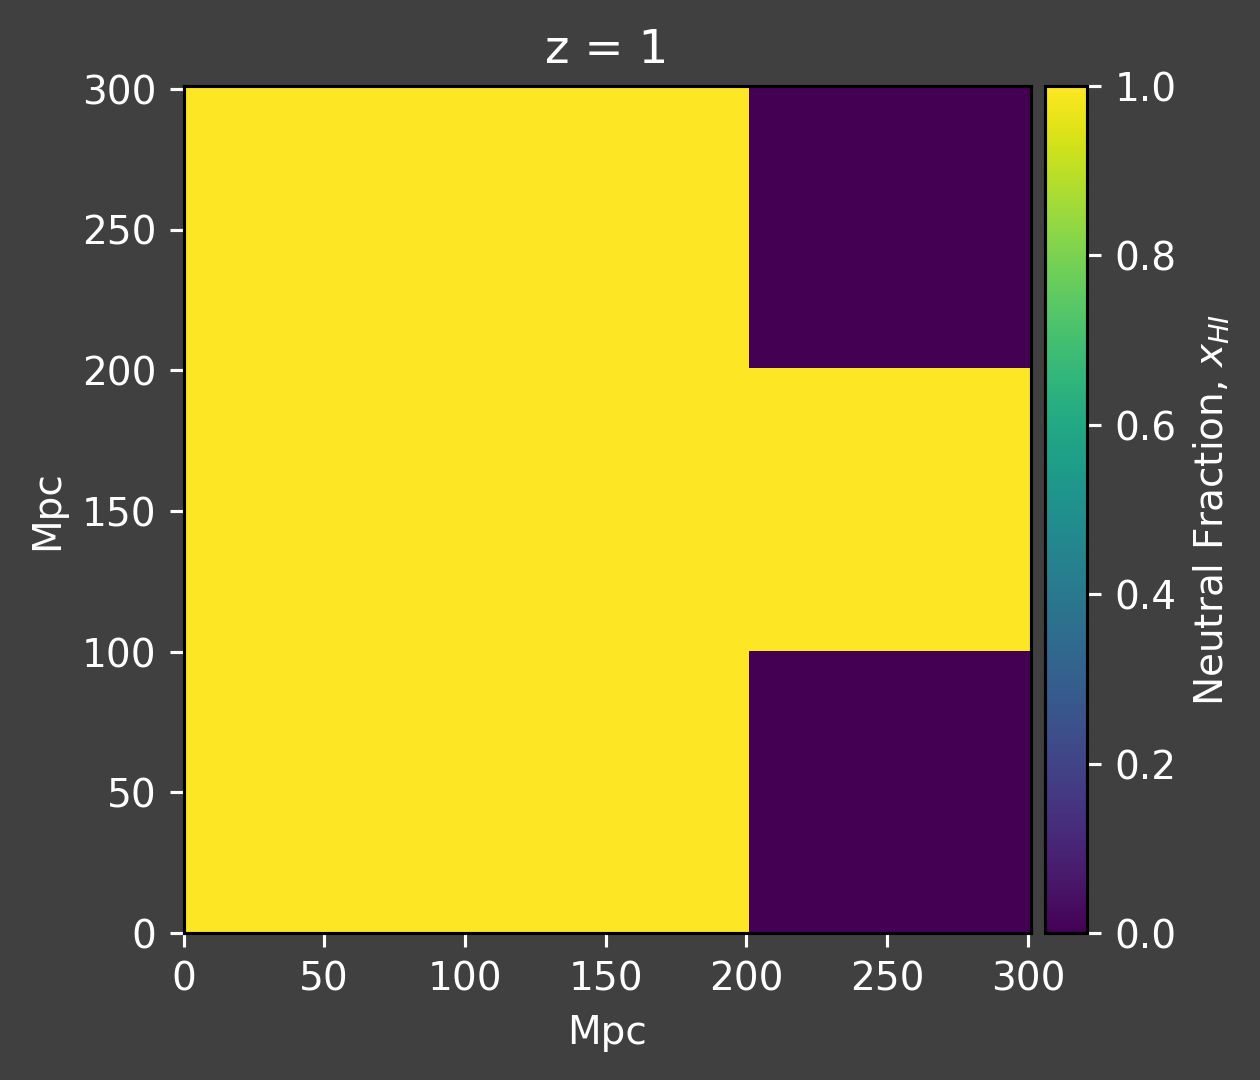

In [79]:
colorplot(1)

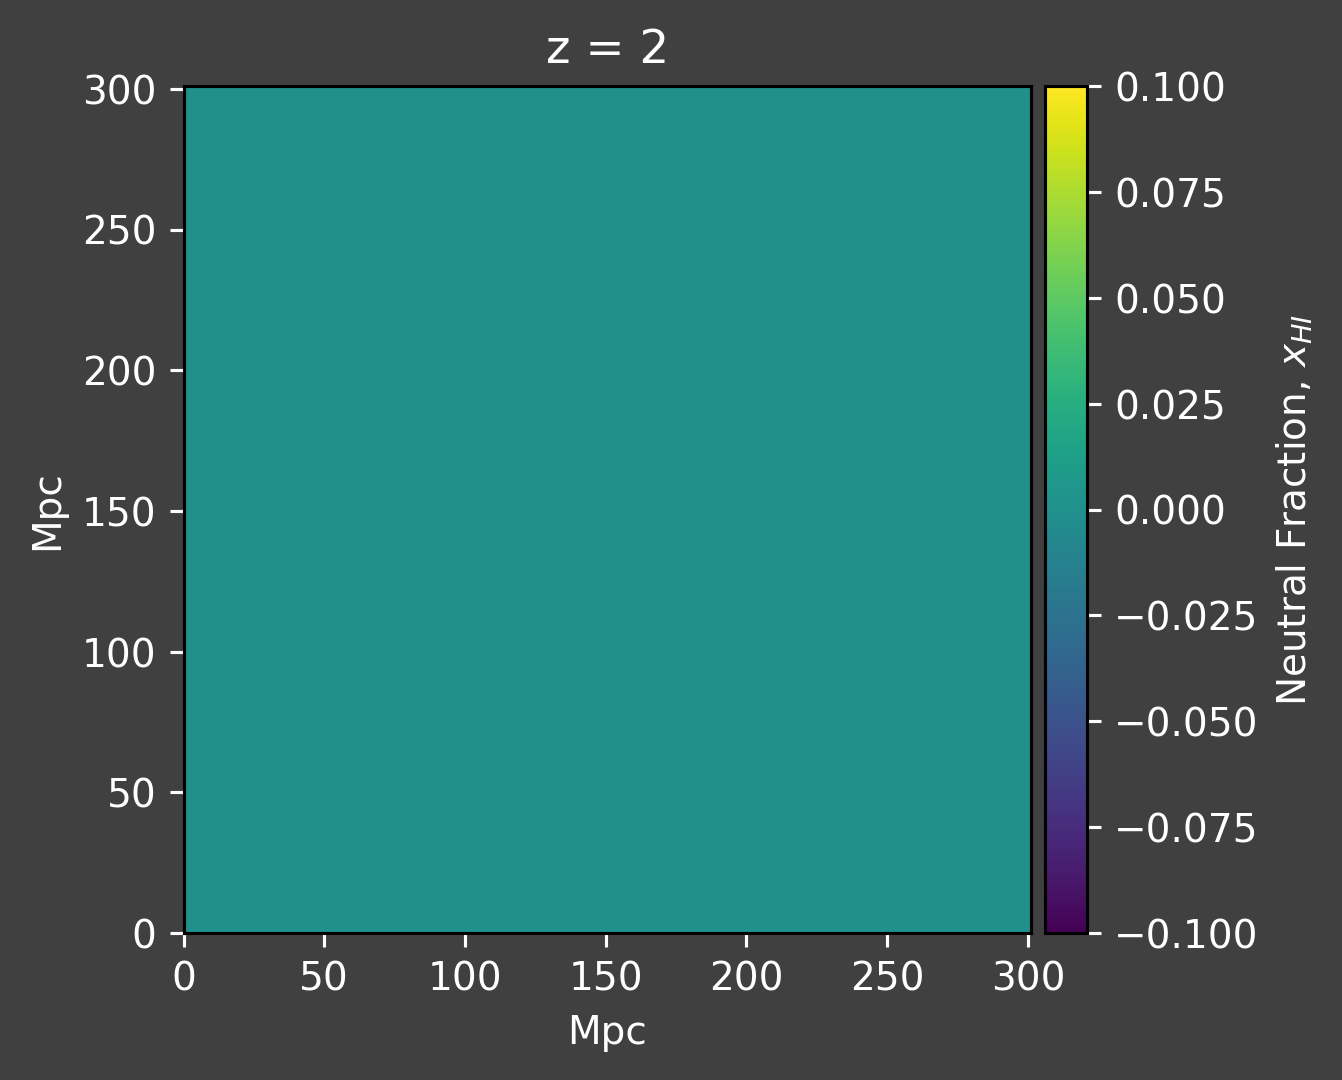

In [80]:
colorplot(2)

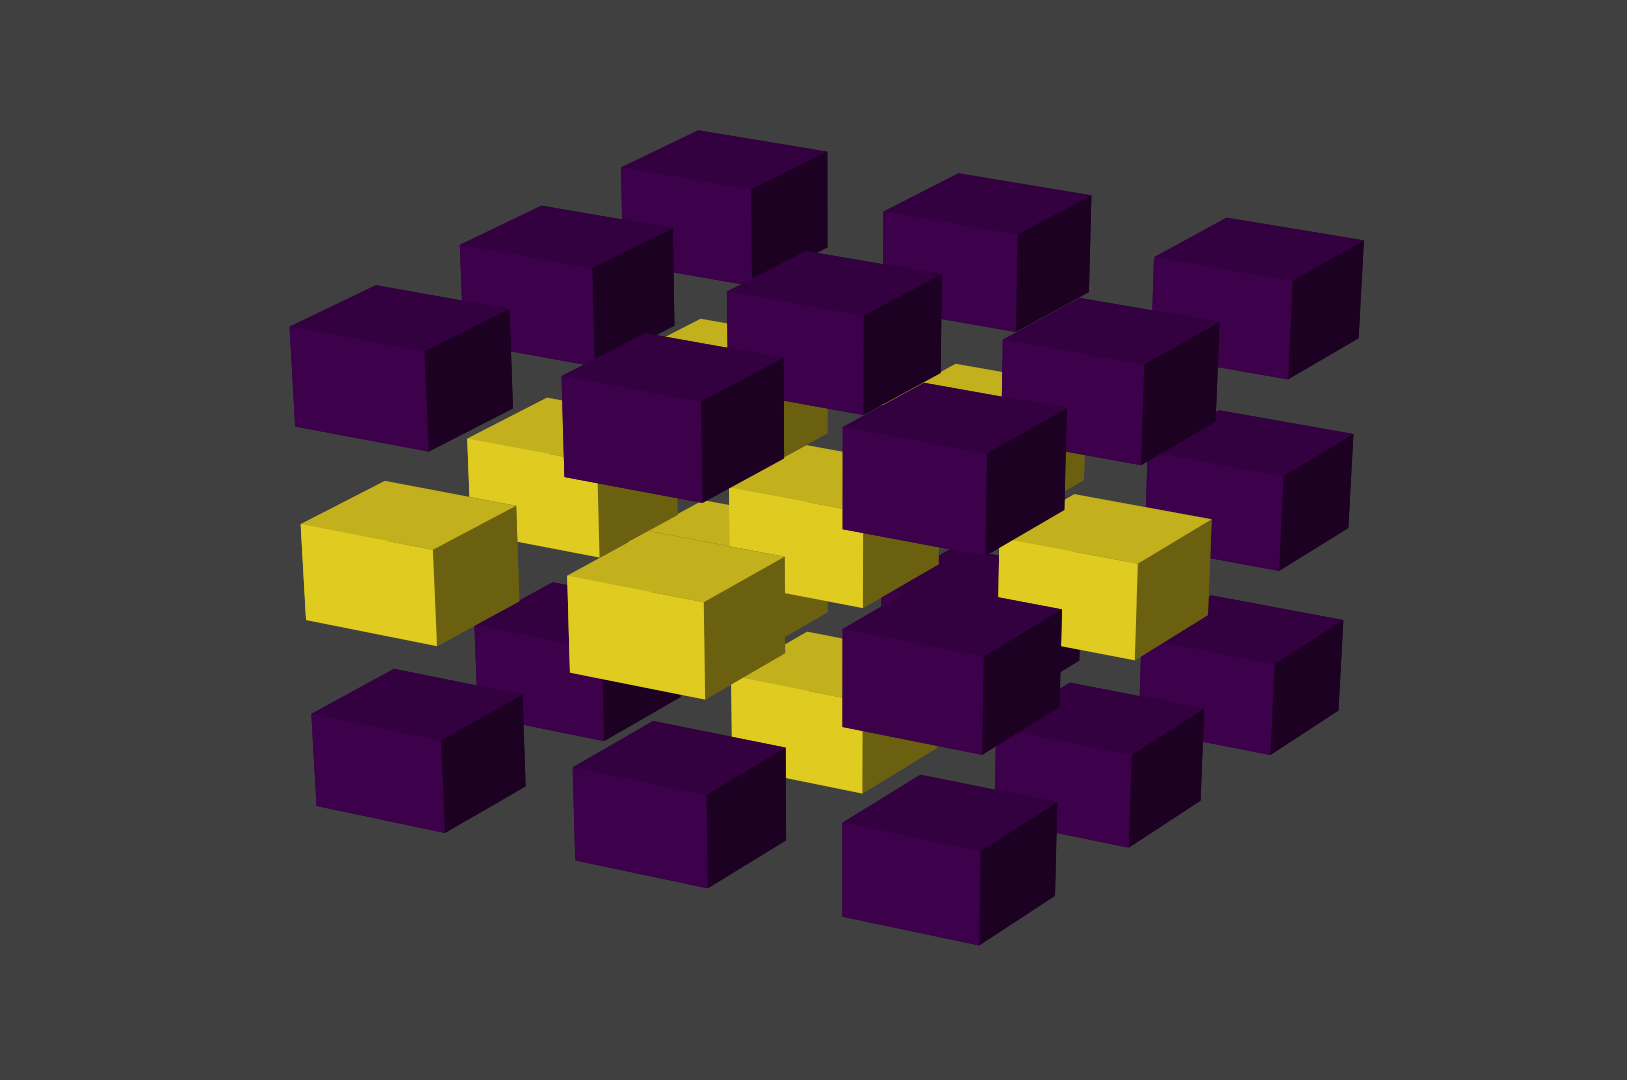

In [67]:
def connectivity1(i=0):
    
    dim = 5
    
    one_frac = np.linspace(1., dim//2, dim//2)

    # prepare some coordinates
    x, y, z = np.indices((dim, dim, dim))

    # draw cuboids in the top left and bottom right corners, and a link between them
    cube0 = (x >= dim//2) & (y >= dim//2) & (z >= dim//2) & (x < dim//2 + 1) & (y < dim//2 + 1) & (z < dim//2 + 1)
    cube1 = (x >= dim//2) & (y >= dim//2) & (z >= dim//2 + one_frac[i]) & (x < dim//2 + 1) & (y < dim//2 + 1) & (z < dim//2 + 1 + one_frac[i])
    cube2 = (x >= dim//2) & (y >= dim//2) & (z >= dim//2 - one_frac[i]) & (x < dim//2 + 1) & (y < dim//2 + 1) & (z < dim//2 + 1 - one_frac[i])
    cube3 = (x >= dim//2) & (y >= dim//2 + one_frac[i]) & (z >= dim//2) & (x < dim//2 + 1) & (y < dim//2 + 1 + one_frac[i]) & (z < dim//2 + 1)
    cube4 = (x >= dim//2) & (y >= dim//2 - one_frac[i]) & (z >= dim//2) & (x < dim//2 + 1) & (y < dim//2 + 1 - one_frac[i]) & (z < dim//2 + 1)
    cube5 = (x >= dim//2 + one_frac[i]) & (y >= dim//2) & (z >= dim//2) & (x < dim//2 + 1 + one_frac[i]) & (y < dim//2 + 1) & (z < dim//2 + 1)
    cube6 = (x >= dim//2 - one_frac[i]) & (y >= dim//2) & (z >= dim//2) & (x < dim//2 + 1 - one_frac[i]) & (y < dim//2 + 1) & (z < dim//2 + 1)
    cube7 = (x >= dim//2) & (y >= dim//2 + one_frac[i]) & (z >= dim//2 + one_frac[i]) & (x < dim//2 + 1) & (y < dim//2 + 1 + one_frac[i]) & (z < dim//2 + 1 + one_frac[i])
    cube8 = (x >= dim//2) & (y >= dim//2 - one_frac[i]) & (z >= dim//2 + one_frac[i]) & (x < dim//2 + 1) & (y < dim//2 + 1 - one_frac[i]) & (z < dim//2 + 1 + one_frac[i])
    cube9 = (x >= dim//2) & (y >= dim//2 + one_frac[i]) & (z >= dim//2 - one_frac[i]) & (x < dim//2 + 1) & (y < dim//2 + 1 + one_frac[i]) & (z < dim//2 + 1 - one_frac[i])
    cube10 = (x >= dim//2) & (y >= dim//2 - one_frac[i]) & (z >= dim//2 - one_frac[i]) & (x < dim//2 + 1) & (y < dim//2 + 1 - one_frac[i]) & (z < dim//2 + 1 - one_frac[i])
    cube11 = (x >= dim//2 + one_frac[i]) & (y >= dim//2 + one_frac[i]) & (z >= dim//2) & (x < dim//2 + 1 + one_frac[i]) & (y < dim//2 + 1 + one_frac[i]) & (z < dim//2 + 1)
    cube12 = (x >= dim//2 - one_frac[i]) & (y >= dim//2 + one_frac[i]) & (z >= dim//2) & (x < dim//2 + 1 - one_frac[i]) & (y < dim//2 + 1 + one_frac[i]) & (z < dim//2 + 1)
    cube13 = (x >= dim//2 + one_frac[i]) & (y >= dim//2 - one_frac[i]) & (z >= dim//2) & (x < dim//2 + 1 + one_frac[i]) & (y < dim//2 + 1 - one_frac[i]) & (z < dim//2 + 1)
    cube14 = (x >= dim//2 - one_frac[i]) & (y >= dim//2 - one_frac[i]) & (z >= dim//2) & (x < dim//2 + 1 - one_frac[i]) & (y < dim//2 + 1 - one_frac[i]) & (z < dim//2 + 1)
    cube15 = (x >= dim//2 + one_frac[i]) & (y >= dim//2) & (z >= dim//2 + one_frac[i]) & (x < dim//2 + 1 + one_frac[i]) & (y < dim//2 + 1) & (z < dim//2 + 1 + one_frac[i])
    cube16 = (x >= dim//2 + one_frac[i]) & (y >= dim//2) & (z >= dim//2 - one_frac[i]) & (x < dim//2 + 1 + one_frac[i]) & (y < dim//2 + 1) & (z < dim//2 + 1 - one_frac[i])
    cube17 = (x >= dim//2 - one_frac[i]) & (y >= dim//2) & (z >= dim//2 + one_frac[i]) & (x < dim//2 + 1 - one_frac[i]) & (y < dim//2 + 1) & (z < dim//2 + 1 + one_frac[i])
    cube18 = (x >= dim//2 - one_frac[i]) & (y >= dim//2) & (z >= dim//2 - one_frac[i]) & (x < dim//2 + 1 - one_frac[i]) & (y < dim//2 + 1) & (z < dim//2 + 1 - one_frac[i])
    cube19 = (x >= dim//2 + one_frac[i]) & (y >= dim//2 + one_frac[i]) & (z >= dim//2 + one_frac[i]) & (x < dim//2 + 1 + one_frac[i]) & (y < dim//2 + 1 + one_frac[i]) & (z < dim//2 + 1 + one_frac[i])
    cube20 = (x >= dim//2 - one_frac[i]) & (y >= dim//2 + one_frac[i]) & (z >= dim//2 + one_frac[i]) & (x < dim//2 + 1 - one_frac[i]) & (y < dim//2 + 1 + one_frac[i]) & (z < dim//2 + 1 + one_frac[i])
    cube21 = (x >= dim//2 + one_frac[i]) & (y >= dim//2 - one_frac[i]) & (z >= dim//2 + one_frac[i]) & (x < dim//2 + 1 + one_frac[i]) & (y < dim//2 + 1 - one_frac[i]) & (z < dim//2 + 1 + one_frac[i])
    cube22 = (x >= dim//2 + one_frac[i]) & (y >= dim//2 + one_frac[i]) & (z >= dim//2 - one_frac[i]) & (x < dim//2 + 1 + one_frac[i]) & (y < dim//2 + 1 + one_frac[i]) & (z < dim//2 + 1 - one_frac[i])
    cube23 = (x >= dim//2 - one_frac[i]) & (y >= dim//2 - one_frac[i]) & (z >= dim//2 + one_frac[i]) & (x < dim//2 + 1 - one_frac[i]) & (y < dim//2 + 1 - one_frac[i]) & (z < dim//2 + 1 + one_frac[i])
    cube24 = (x >= dim//2 + one_frac[i]) & (y >= dim//2 - one_frac[i]) & (z >= dim//2 - one_frac[i]) & (x < dim//2 + 1 + one_frac[i]) & (y < dim//2 + 1 - one_frac[i]) & (z < dim//2 + 1 - one_frac[i])
    cube25 = (x >= dim//2 - one_frac[i]) & (y >= dim//2 + one_frac[i]) & (z >= dim//2 - one_frac[i]) & (x < dim//2 + 1 - one_frac[i]) & (y < dim//2 + 1 + one_frac[i]) & (z < dim//2 + 1 - one_frac[i])
    cube26 = (x >= dim//2 - one_frac[i]) & (y >= dim//2 - one_frac[i]) & (z >= dim//2 - one_frac[i]) & (x < dim//2 + 1 - one_frac[i]) & (y < dim//2 + 1 - one_frac[i]) & (z < dim//2 + 1 - one_frac[i])

    
    # combine the objects into a single boolean array
    voxels = cube0 | cube1 | cube2 | cube3 | cube4 | cube5 | cube6 | cube7 | cube8 | cube9 | cube10 | cube11 | cube12 | cube13 | cube14 | cube15 | cube16 | cube17 | cube18 | cube19 | cube20 | cube21 | cube22 | cube23 | cube24 | cube25 | cube26

    cmap = plt.get_cmap('viridis')
    vir_color = cmap(np.linspace(0, 1, 2))    
    
    # set the colors of each object
    colors = np.zeros(voxels.shape + (4,))
    colors[cube0] = vir_color[int(ap[1, 1, 1])]  # z = 1, y = 1, x = 1
    colors[cube1] = vir_color[int(ap[2, 1, 1])]  # z = 2, y = 1, x = 1
    colors[cube2] = vir_color[int(ap[0, 1, 1])]  # z = 0, y = 1, x = 1
    colors[cube3] = vir_color[int(ap[1, 2, 1])]  # z = 1, y = 2, x = 1
    colors[cube4] = vir_color[int(ap[1, 0, 1])]  # z = 1, y = 0, x = 1
    colors[cube5] = vir_color[int(ap[1, 1, 2])]  # z = 1, y = 1, x = 2
    colors[cube6] = vir_color[int(ap[1, 1, 0])]  # z = 1, y = 1, x = 0
    colors[cube7] = vir_color[int(ap[2, 2, 1])]  # z = 2, y = 2, x = 1
    colors[cube8] = vir_color[int(ap[2, 0, 1])]  # z = 2, y = 0, x = 1
    colors[cube9] = vir_color[int(ap[0, 2, 1])]  # z = 0, y = 2, x = 1
    colors[cube10] = vir_color[int(ap[0, 0, 1])]  # z = 0, y = 0, x = 1
    colors[cube11] = vir_color[int(ap[1, 2, 2])]  # z = 1, y = 2, x = 2
    colors[cube12] = vir_color[int(ap[1, 2, 0])]  # z = 1, y = 2, x = 0
    colors[cube13] = vir_color[int(ap[1, 0, 2])]  # z = 1, y = 0, x = 2
    colors[cube14] = vir_color[int(ap[1, 0, 0])]  # z = 1, y = 0, x = 0
    colors[cube15] = vir_color[int(ap[2, 1, 2])]  # z = 2, y = 1, x = 2
    colors[cube16] = vir_color[int(ap[0, 1, 2])]  # z = 0, y = 1, x = 2
    colors[cube17] = vir_color[int(ap[2, 1, 0])]  # z = 2, y = 1, x = 0
    colors[cube18] = vir_color[int(ap[0, 1, 0])]  # z = 0, y = 1, x = 0
    colors[cube19] = vir_color[int(ap[2, 2, 2])]  # z = 2, y = 2, x = 2
    colors[cube20] = vir_color[int(ap[2, 2, 0])]  # z = 2, y = 2, x = 0
    colors[cube21] = vir_color[int(ap[2, 0, 2])]  # z = 2, y = 0, x = 2
    colors[cube22] = vir_color[int(ap[0, 2, 2])]  # z = 0, y = 2, x = 2
    colors[cube23] = vir_color[int(ap[2, 0, 0])]  # z = 2, y = 0, x = 0
    colors[cube24] = vir_color[int(ap[0, 0, 2])]  # z = 0, y = 0, x = 2
    colors[cube25] = vir_color[int(ap[0, 2, 0])]  # z = 0, y = 2, x = 0
    colors[cube26] = vir_color[int(ap[0, 0, 0])]  # z = 0, y = 0, x = 0

    # and plot everything
    fig = plt.figure(dpi=335.5, facecolor='#404040')
    ax = fig.gca(projection='3d')
    ax.set_facecolor('#404040')
    ax.voxels(voxels, facecolors=colors)
    ax.set_axis_off()
#     ax.view_init(0., 0.)

    plt.show()
    
connectivity1(-1)

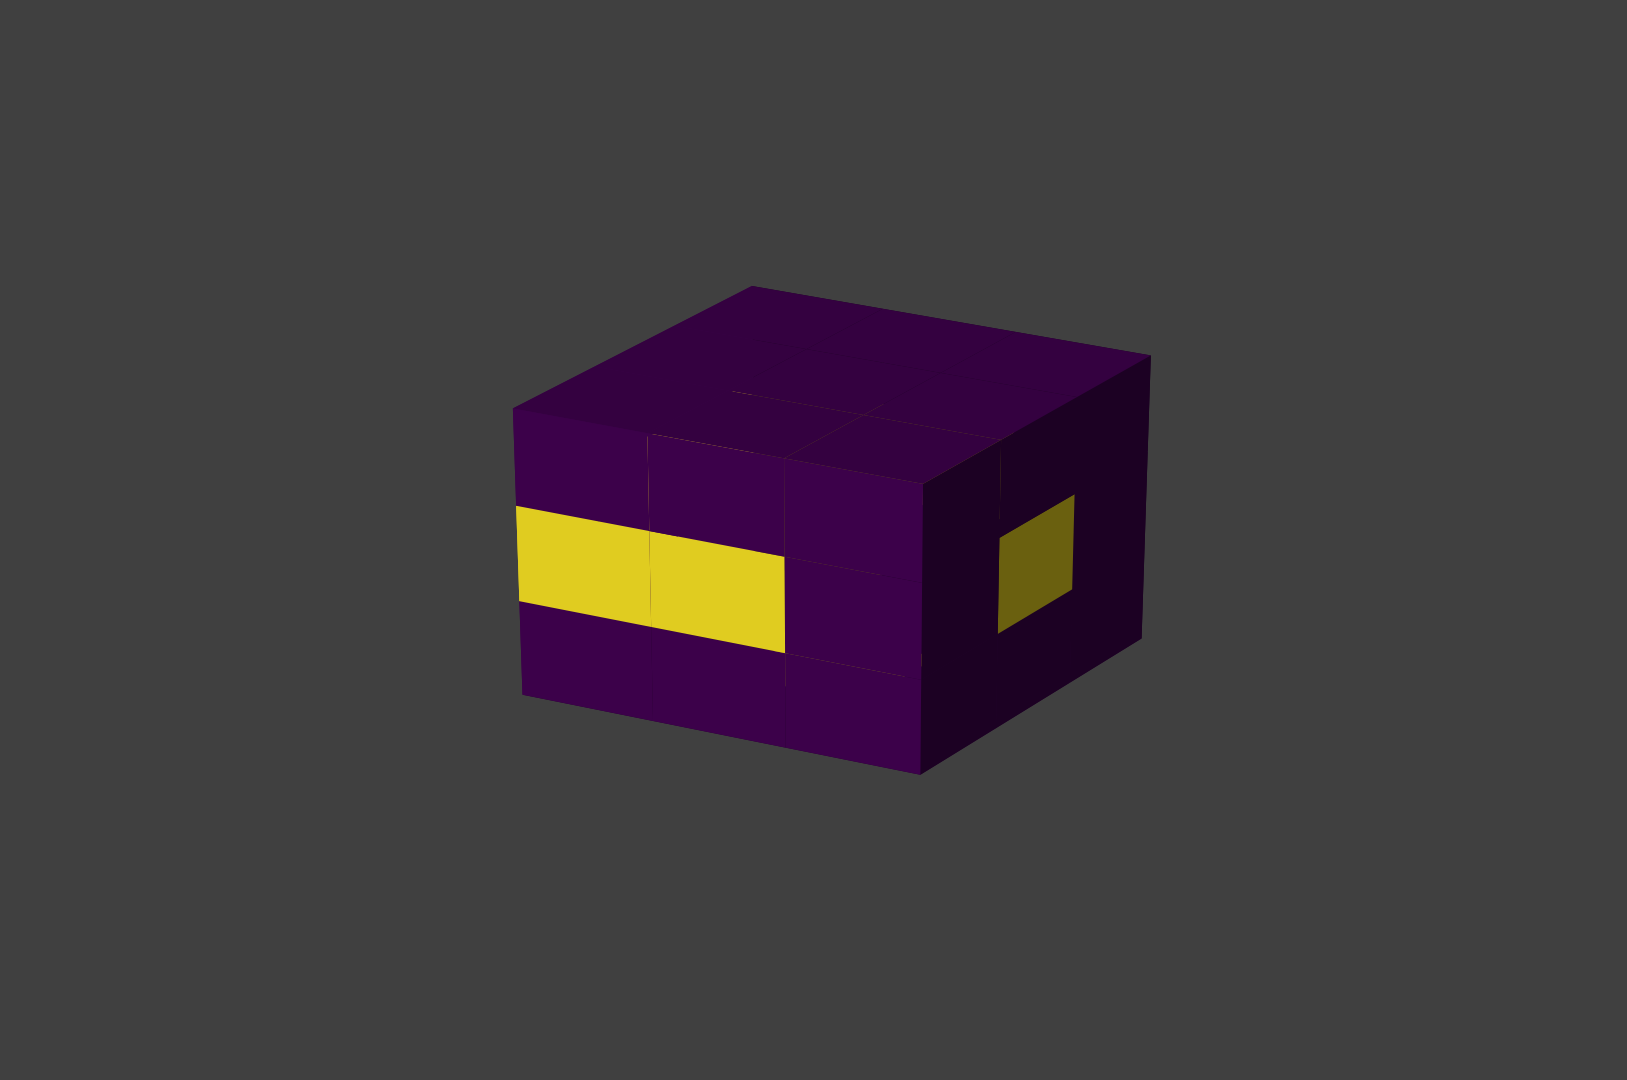

In [68]:
connectivity1(0)

In [120]:
# https://terbium.io/2017/12/matplotlib-3d/

from matplotlib import cm

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    ax.set_axis_off()
    ax.set_facecolor('#404040')
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    plt.show()

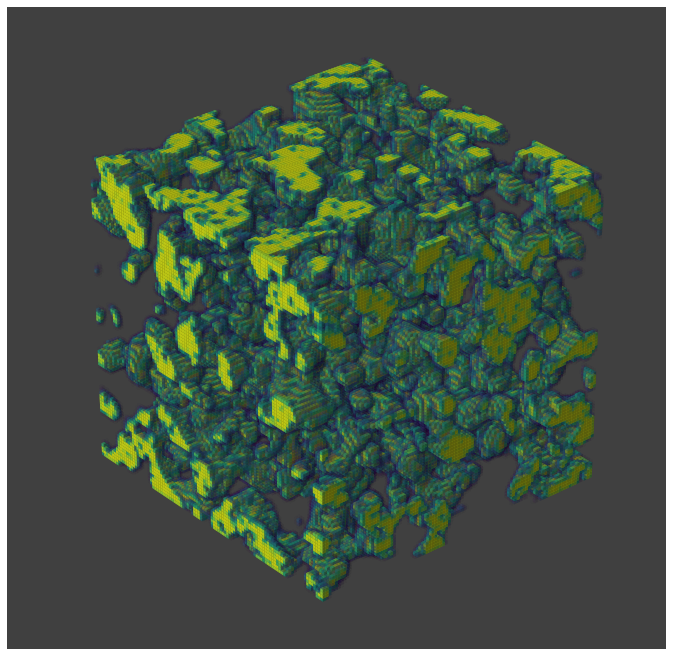

In [125]:
IMG_DIM = 100

ap2 = reducedBox(newDIM=IMG_DIM)
plot_cube(ap2)

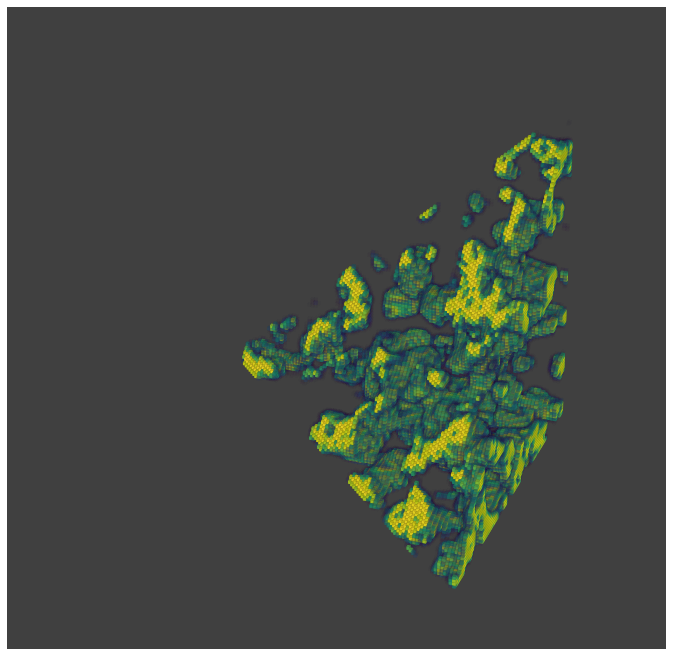

In [126]:
cube = np.copy(ap2)
for x in range(0, IMG_DIM):
    for y in range(0, IMG_DIM):
        for z in range(max(x-y+5, 0), IMG_DIM):
            cube[x, y, z] = 0
plot_cube(cube, angle=200)

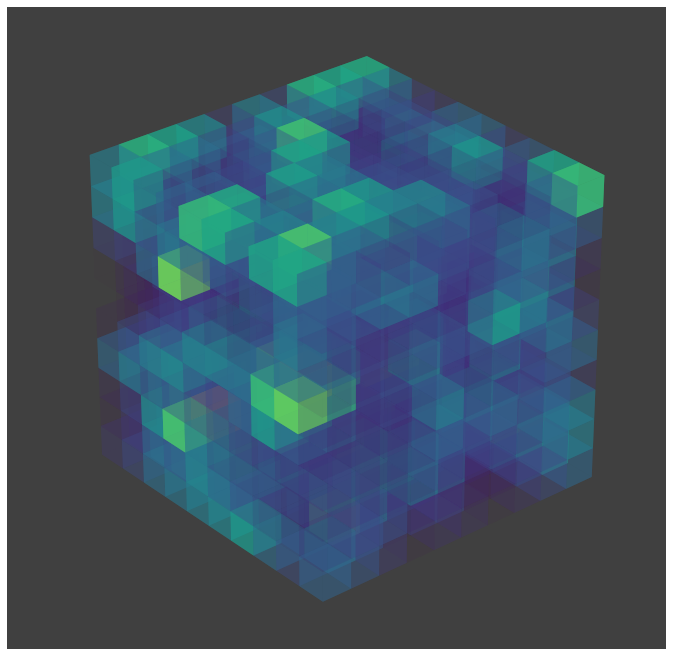

In [91]:
IMG_DIM = 10

ap2 = reducedBox(newDIM=IMG_DIM)
plot_cube(ap2)

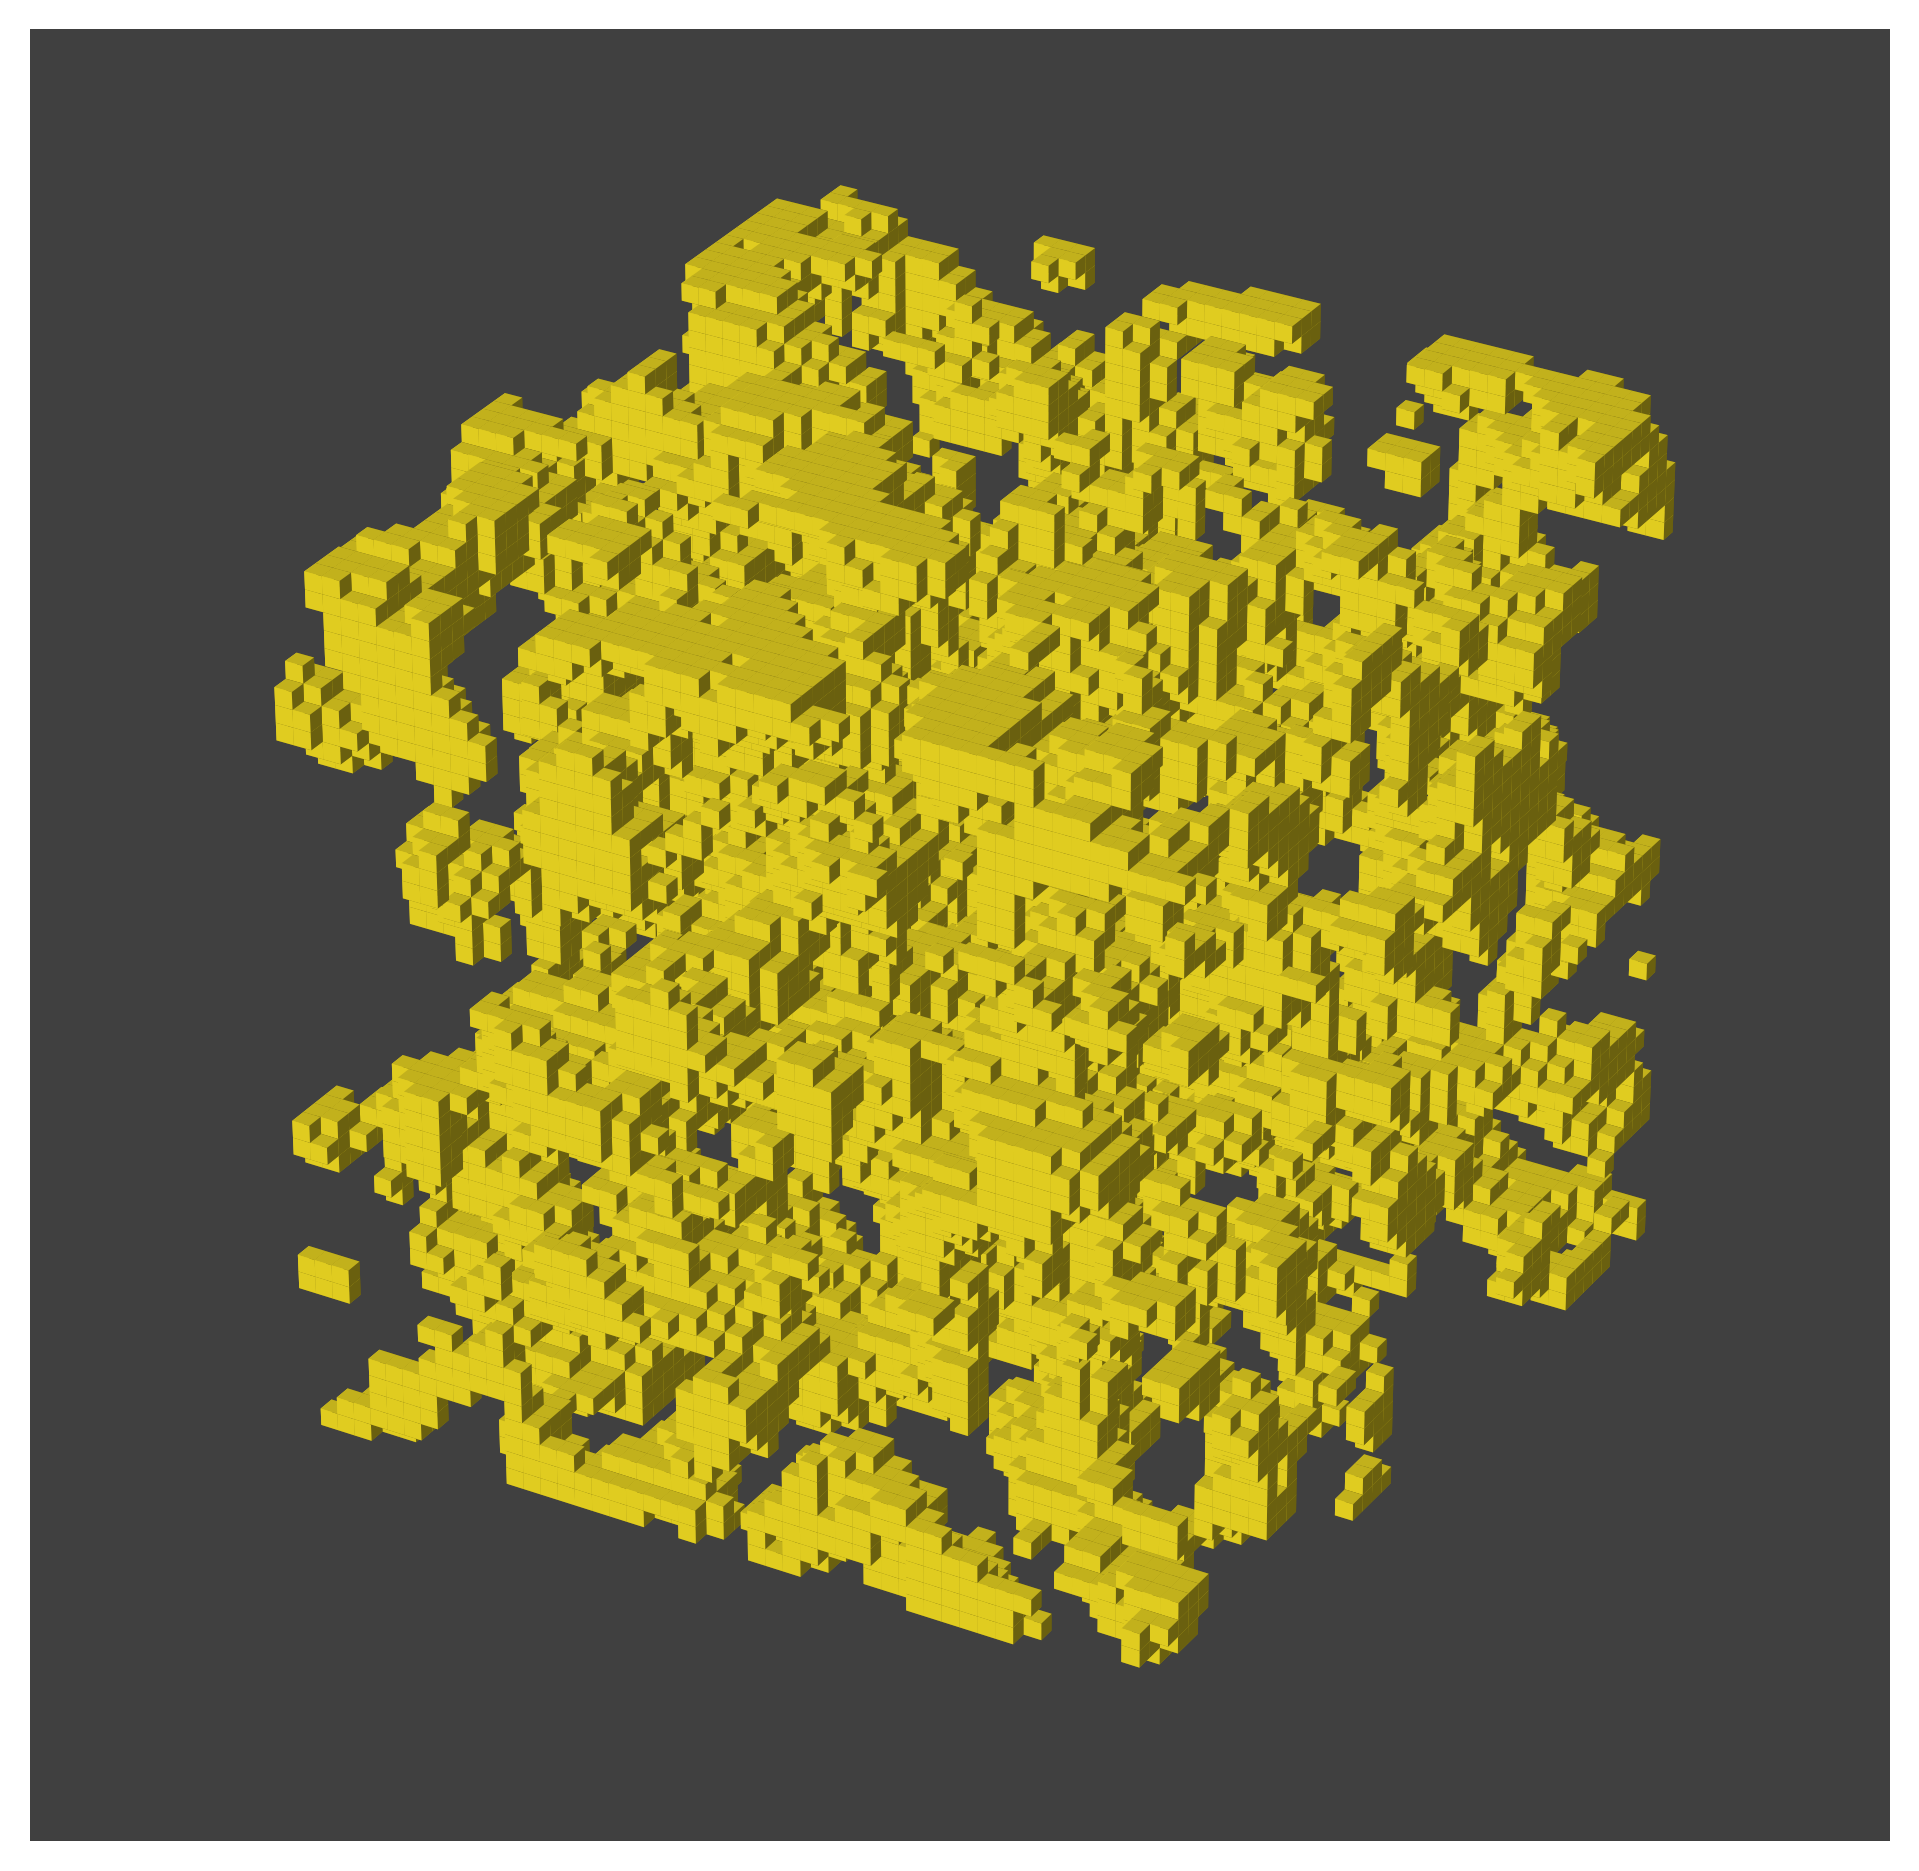

<Figure size 432x288 with 0 Axes>

In [85]:
ap2 = np.round(reducedBox(newDIM=50))
plot_cube(ap2)

In [97]:
IMG_DIM = 10
